# Startup notebook for linear analysis of connectivity for fMRI data

This notebook provides the first steps to calculate connectivity estimates for the movie dataset.
The data were recorded in an fMRI experiment where subjects were in one of two conditions (over 5 sessions): 2 for resting state and 3 for movie viewing.

BE CAREFUL ABOUT POSSIBLE CHANGES OF NOTATIONS ACROSS NOTEBOOKS (N = number of subjects here...)


In [35]:
import numpy as np
import matplotlib.pyplot as plt

ts = np.load("../datasets/movie/ts_emp.npy")  # load data

N = ts.shape[0]  # number of subjects
v_C = np.array([0, 0, 1, 1, 1])  # conditions, 0=rest and 1=movie
C = v_C.size
T = ts.shape[3]  # number of time samples
P = ts.shape[2]  # number of ROIs in the parcellation

print("number of subjects: {0} \nthere are {1} resting sessions \nand {2} movie sessions\neach session has {3} time samples and {4} ROIs\nthe dataset ts has shape: {5}".format(N, np.sum(C==0), np.sum(C==1), T, P, ts.shape))

number of subjects: 22 
there are 0 resting sessions 
and 0 movie sessions
each session has 300 time samples and 66 ROIs
the dataset ts has shape: (22, 5, 66, 300)


# Calculate functional connectivity (FC)

We calculate the Pearson correlation for each session.

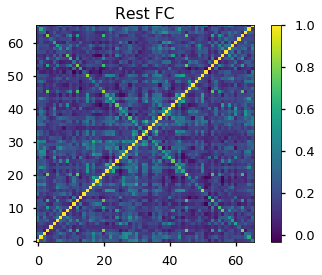

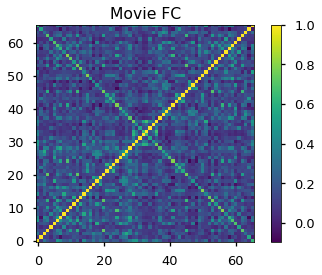

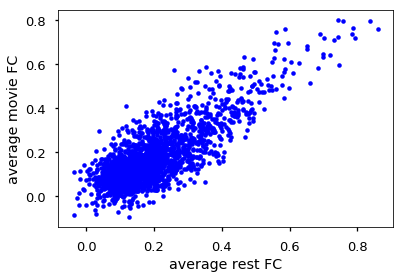

In [39]:
# demean
for n in range(N): # loop over subjects
    for c in range(C): # loop over sessions
        ts[n,c,:,:] -= np.outer(ts[n,c,:,:].mean(axis=1),np.ones([T]))

# PxP matrix of Pearson correlation values for each session
K = np.zeros([N,C,P,P])
for n in range(N): # loop over subjects
    for c in range(C): # loop over sessions
        K[n,c,:,:] = np.tensordot(ts[n,c,:,0:T-1],ts[n,c,:,0:T-1],axes=(1,1)) / (T-2) # covariances
        K[n,c,:,:] /= np.sqrt(np.outer(K[n,c,:,:].diagonal(),K[n,c,:,:].diagonal()))

        
# mean FC matrices over all subjects and sessions for the 2 conditions
rest_FC = K[:,0:2,:,:].mean(axis=(0,1))
movie_FC = K[:,2:5,:,:].mean(axis=(0,1))
        
    
# plots

plt.figure()
plt.title('Rest FC')
plt.imshow(rest_FC,interpolation='nearest',origin='bottom')
plt.colorbar()
    
plt.figure()
plt.title('Movie FC')
plt.imshow(movie_FC,interpolation='nearest',origin='bottom')
plt.colorbar()

mask_tri = np.tri(P,P,-1,dtype=np.bool)
plt.figure()
plt.plot(rest_FC[mask_tri],movie_FC[mask_tri],'.b')
plt.xlabel('average rest FC')
plt.ylabel('average movie FC')

plt.show()


# Statistical tesing to identifiy connections that change across conditions

We use Welsch t-test (with unequal variances) to compare the distribution of FC values between the 2 conditions (rest and movie) for each connection.
This illustrates the issue of multiple comparions when using connectivity estimates.


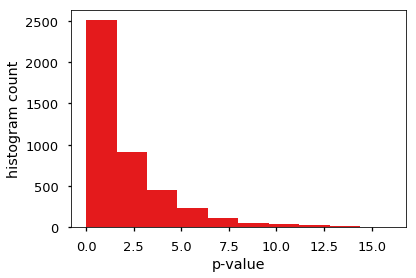

In [37]:
import scipy.stats as stt

# test for each pair of ROIs the p-value 
pval = np.ones([P,P])
for p1 in range(P): # loop over target ROIs
    for p0 in range(P): # loop over source ROIs
        if not p1==p0:
            pval[p1,p0] = stt.ttest_ind(K[:,0:2,p1,p0].flatten(),K[:,2:5,p1,p0].flatten(),equal_var=False)[1]

            
plt.figure()
plt.hist(-np.log10(pval.flatten()))
plt.xlabel('p-value')
plt.ylabel('histogram count')

plt.show()